In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [43]:
!pip install tune-sklearn

     |████████████████████████████████| 40 kB 5.7 MB/s 
     |████████████████████████████████| 59.6 MB 1.2 MB/s 
     |████████████████████████████████| 175 kB 59.4 MB/s 
     |████████████████████████████████| 125 kB 70.0 MB/s 


In [44]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers.convolutional import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout 
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from tune_sklearn import TuneGridSearchCV
from keras.layers import Activation
import random as rn
rn.seed(10)

# Load Dataset
##### From Google Drive

In [45]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/processed_data/data_3_months_int.csv")
data = df[["time_scal", "event"]]
#Correcting the TimeScale
data['time_scal'] = data['time_scal'] *10
data.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,time_scal,event
0,0.702025,0
1,0.702037,20
2,0.702037,4
3,0.702037,6
4,0.702037,16


### One Hot Encoding

In [46]:
df = data.reset_index(drop = True)
## initialize 24 * n_datapoints array
len = df.shape[0]
n_event = 24
enc = [[0 for i in range(len)] for j in range(n_event)]
enc = np.array(enc)

## fill array
for i in range(0, df.shape[0]):

    sen = df.loc[i, "event"]
    enc[sen, i] = 1

dt = {"time_scal" :df["time_scal"],'0' : enc[0], '1': enc[1], '2' : enc[2], '3': enc[3], '4': enc[4], '5': enc[5],
      '6' : enc[6], '7': enc[7], '8' : enc[8], '9': enc[9], '10': enc[10], '11': enc[11],
      '12' : enc[12], '13': enc[13], '14' : enc[14], '15': enc[15], '16': enc[16], '17': enc[17],
      '18' : enc[18], '19': enc[19], '20' : enc[20], '21': enc[21], '22': enc[22], '23': enc[23]
      }
df2 = pd.DataFrame(data = dt)
print(df2.shape)

(44223, 25)


# Train-Test Split
- Split the data into Train_data & Test_data
- Batch the data into X_bucket & Y_bucket

#### The train test split was 80%-20%
#### We tried Different Batch sizes and found 20 to be optimum.

In [47]:
#Train-Test Size
train_size = int(df2.shape[0] * 0.8)
test_size = df2.shape[0] - train_size
print(train_size)
print(test_size)

#Split
train_data = df2.iloc[0:train_size, :].values
test_data = df2.iloc[train_size - 20: ,:].values

#Define Batch Size
batch_size = 20

#X & Y Buckets (Train_data)
X_train = []
y_train = []
for i in range(batch_size, train_size):
    X_train.append(train_data[i-batch_size:i, :])
    y_train.append(train_data[i, 1:])


#X & Y Buckets (Test_data)
X_test =[]
y_test =[]
for i in range(batch_size,test_size):
    X_test.append(test_data[i-batch_size:i, :])
    y_test.append(test_data[i, 1:])

#convert X_train &y_train into nupy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

#convert X_test &y_test into nupy arrays
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape, y_test.shape)

35378
8845
(35358, 20, 25) (35358, 24)
(8825, 20, 25) (8825, 24)


# Final LSTM Model

In [40]:
#Bi-dir LSTM
bilstm_model = tf.keras.Sequential()
bilstm_model.add(layers.Bidirectional(layers.LSTM(48, activation='relu', dropout=0.2, return_sequences=False, input_shape=(20,5,25)))) #{sequence_len, no_timesteps, no_features}
bilstm_model.add(layers.Dense(48, activation='sigmoid'))
bilstm_model.add(layers.Dense(24, activation='softmax'))
bilstm_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [41]:
############ Final Model #######
nb_e = 15
b_s = 20
history = bilstm_model.fit(X_train,y_train, batch_size= b_s, validation_split=0.25, verbose=1, epochs= nb_e)
loss, acc = bilstm_model.evaluate(X_test, y_test)

Epoch 1/15
1326/1326 [==============================] - 24s 16ms/step - loss: 1.7302 - accuracy: 0.3880 - val_loss: 1.2231 - val_accuracy: 0.4464
Epoch 2/15
1326/1326 [==============================] - 20s 15ms/step - loss: 1.1846 - accuracy: 0.6357 - val_loss: 0.5688 - val_accuracy: 0.8658
Epoch 3/15
1326/1326 [==============================] - 20s 15ms/step - loss: 0.8507 - accuracy: 0.7850 - val_loss: 0.4802 - val_accuracy: 0.8928
Epoch 4/15
1326/1326 [==============================] - 21s 15ms/step - loss: 0.7800 - accuracy: 0.8010 - val_loss: 0.4526 - val_accuracy: 0.8993
Epoch 5/15
1326/1326 [==============================] - 21s 16ms/step - loss: 0.7446 - accuracy: 0.8060 - val_loss: 0.4321 - val_accuracy: 0.8976
Epoch 6/15
1326/1326 [==============================] - 20s 15ms/step - loss: 0.7208 - accuracy: 0.8114 - val_loss: 0.4370 - val_accuracy: 0.8972
Epoch 7/15
1326/1326 [==============================] - 20s 15ms/step - loss: 0.7018 - accuracy: 0.8151 - val_loss: 0.4330 -

In [ ]:
############ Final Model #######
nb_e = 15
b_s = 20
history = sl_model.fit(X_train,y_train, batch_size= b_s, validation_split=0.25, verbose=1, epochs= nb_e)
loss, acc = sl_model.evaluate(X_test, y_test)

Epoch 1/15
1266/1266 [==============================] - 28s 20ms/step - loss: 1.4598 - accuracy: 0.5562 - val_loss: 0.7524 - val_accuracy: 0.8309
Epoch 2/15
1266/1266 [==============================] - 25s 20ms/step - loss: 0.9126 - accuracy: 0.7561 - val_loss: 0.6144 - val_accuracy: 0.8551
Epoch 3/15
1266/1266 [==============================] - 25s 20ms/step - loss: 0.8108 - accuracy: 0.7920 - val_loss: 0.5448 - val_accuracy: 0.8713
Epoch 4/15
1266/1266 [==============================] - 25s 19ms/step - loss: 0.7646 - accuracy: 0.8012 - val_loss: 0.5439 - val_accuracy: 0.8699
Epoch 5/15
1266/1266 [==============================] - 24s 19ms/step - loss: 0.7389 - accuracy: 0.8062 - val_loss: 0.5275 - val_accuracy: 0.8739
Epoch 6/15
1266/1266 [==============================] - 24s 19ms/step - loss: 0.7279 - accuracy: 0.8090 - val_loss: 0.5268 - val_accuracy: 0.8731
Epoch 7/15
1266/1266 [==============================] - 24s 19ms/step - loss: 0.7037 - accuracy: 0.8129 - val_loss: 0.5183 -

In [ ]:
bilstm_model.summary()
bilstm_model.save("lstm_model.h5")

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 96)               28416     
 nal)                                                            
                                                                 
 dense_69 (Dense)            (None, 48)                4656      
                                                                 
 dense_70 (Dense)            (None, 24)                1176      
                                                                 
Total params: 34,248
Trainable params: 34,248
Non-trainable params: 0
_________________________________________________________________


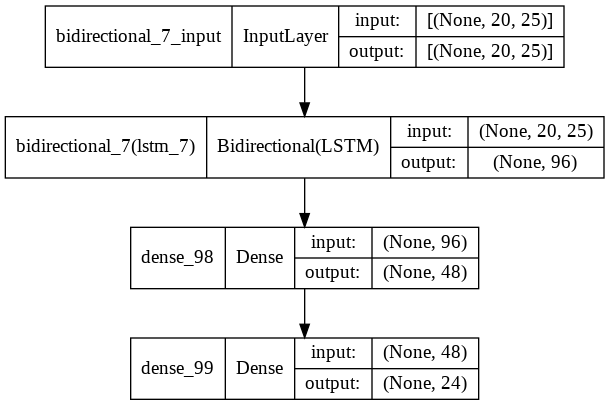

In [ ]:
plot_model(bilstm_model, to_file='bilstm_model_plot.png', show_shapes=True, show_layer_names=True)

### Other Varients of LSTM


In [39]:
nb_e = 20
b_s = 20
history = bilstm_model.fit(X_train,y_train, batch_size= b_s, validation_split=0.25, verbose=1, epochs= nb_e)
loss, acc = bilstm_model.evaluate(X_test, y_test)

Epoch 1/20
1326/1326 [==============================] - 24s 16ms/step - loss: 1.5793 - accuracy: 0.5216 - val_loss: 0.7386 - val_accuracy: 0.8153
Epoch 2/20
1326/1326 [==============================] - 20s 15ms/step - loss: 0.9995 - accuracy: 0.7129 - val_loss: 0.5464 - val_accuracy: 0.8839
Epoch 3/20
1326/1326 [==============================] - 20s 15ms/step - loss: 0.8348 - accuracy: 0.7886 - val_loss: 0.4763 - val_accuracy: 0.8934
Epoch 4/20
1326/1326 [==============================] - 20s 15ms/step - loss: 0.7741 - accuracy: 0.8005 - val_loss: 0.4782 - val_accuracy: 0.8966
Epoch 5/20
1326/1326 [==============================] - 20s 15ms/step - loss: 0.7439 - accuracy: 0.8038 - val_loss: 0.4434 - val_accuracy: 0.8971
Epoch 6/20
1326/1326 [==============================] - 20s 15ms/step - loss: 0.7285 - accuracy: 0.8072 - val_loss: 0.4513 - val_accuracy: 0.8966
Epoch 7/20
1326/1326 [==============================] - 20s 15ms/step - loss: 0.7063 - accuracy: 0.8134 - val_loss: 0.4436 -

In [ ]:
nb_e = 50
b_s = 20
history = bilstm_model.fit(X_train,y_train, batch_size= b_s, validation_split=0.25, verbose=1, epochs= nb_e)
loss, acc = bilstm_model.evaluate(X_test, y_test)

Epoch 1/50
1326/1326 [==============================] - 50s 35ms/step - loss: 1.5973 - accuracy: 0.4632 - val_loss: 1.0551 - val_accuracy: 0.5286
Epoch 2/50
1326/1326 [==============================] - 40s 30ms/step - loss: 0.9176 - accuracy: 0.7519 - val_loss: 0.4922 - val_accuracy: 0.8753
Epoch 3/50
1326/1326 [==============================] - 39s 30ms/step - loss: 0.8063 - accuracy: 0.7815 - val_loss: 0.4566 - val_accuracy: 0.8949
Epoch 4/50
1326/1326 [==============================] - 40s 30ms/step - loss: 0.7542 - accuracy: 0.8063 - val_loss: 0.4554 - val_accuracy: 0.8973
Epoch 5/50
1326/1326 [==============================] - 41s 31ms/step - loss: 0.7178 - accuracy: 0.8136 - val_loss: 0.4368 - val_accuracy: 0.8963
Epoch 6/50
1326/1326 [==============================] - 40s 30ms/step - loss: 0.6985 - accuracy: 0.8168 - val_loss: 0.4417 - val_accuracy: 0.8960
Epoch 7/50
1326/1326 [==============================] - 40s 30ms/step - loss: 0.6799 - accuracy: 0.8202 - val_loss: 0.4286 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


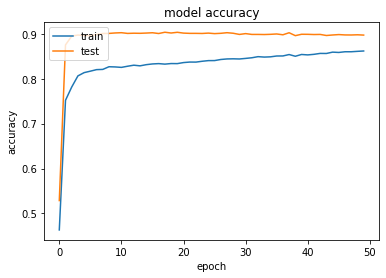

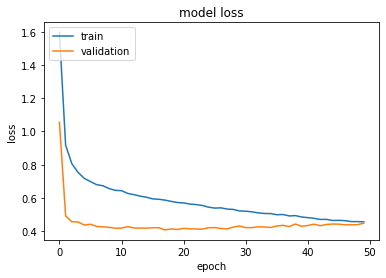

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

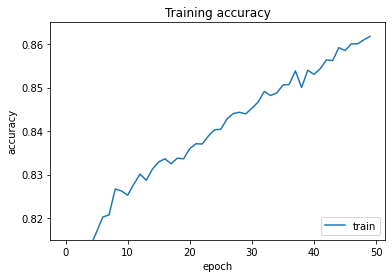

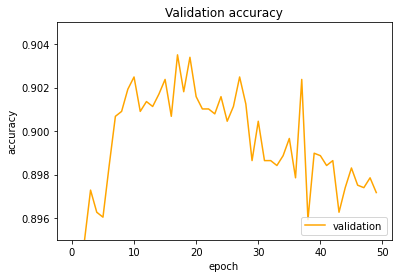

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([ 'train'], loc='lower right')
plt.ylim(0.815, 0.865)
plt.show()

plt.plot(history.history['val_accuracy'], color = '#FFA500')
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([ 'validation'], loc='lower right')
plt.ylim(0.895, 0.905)
plt.show()

In [ ]:
optimizers = ["rmsprop", "adam"]

# define the optimizer function
def create_model(optimizer="rmsprop", kernel_initializer="glorot_uniform"):
  sl_model = tf.keras.Sequential()
  sl_model.add(layers.Bidirectional(layers.LSTM(96, activation='relu', dropout=0.4, return_sequences=False, input_shape=(20,5,24)))) #{sequence_len, no_timesteps, no_features}
  sl_model.add(layers.Dense(48, activation='sigmoid'))
  sl_model.add(layers.Dense(24, activation='softmax'))
  sl_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
  return sl_model

sl_model = KerasClassifier(build_fn=create_model)

kernel_initializer = ["glorot_uniform", "normal"]
epochs = [15, 60]
param_grid = dict(
    optimizer=optimizers,
    nb_epoch=epochs,
    kernel_initializer=kernel_initializer)
grid = TuneGridSearchCV(estimator=sl_model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)
print(grid_result.best_params_)
print(grid_result.cv_results_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ray/tune/tune.py:374: UserWarning: The `loggers` argument is deprecated. Please pass the respective `LoggerCallback` classes to the `callbacks` argument instead. See https://docs.ray.io/en/latest/tune/api_docs/logging.html
  "The `loggers` argument is deprecated. Please pass the respective "
(_Trainable pid=11448) 2022-01-27 00:02:04.195259: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_Trainable pid=11447) 2022-01-27 00:02:04.199731: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Streaming output truncated to the last 5000 lines.
296/883 [=========>....................]
(_Trainable pid=11447)  - ETA: 1:30 - loss: 2.6658 - accuracy: 0.1390
113/883 [==>...........................] - ETA: 2:12 - loss: 2.6421 - accuracy: 0.2044
(_Trainable pid=11448) 
(_Trainable pid=11448) 114/883 [==>...........................] - ETA: 2:12 - loss: 2.6409 - accuracy: 0.2053
546/883 [=================>............] - ETA: 55s - loss: 2.3662 - accuracy: 0.2446
(_Trainable pid=11447)  - ETA: 20s - loss: 2.6095 - accuracy: 0.1491
696/883 [======================>.......] - ETA: 30s - loss: 2.3505 - accuracy: 0.2443
(_Trainable pid=11447) 
(_Trainable pid=11447)   1/221 [..............................] - ETA: 8:45 - loss: 1.7274 - accuracy: 0.4688
718/883 [=======================>......] - ETA: 26s - loss: 2.3460 - accuracy: 0.2455
(_Trainable pid=11447) 

# Final CNN Model

In [48]:
cnn_model = tf.keras.Sequential()
cnn_model.add(Dense(96, activation='relu', input_shape=X_train.shape[1:]))
cnn_model.add(Conv1D(filters=48, kernel_size=24, padding='same', activation='relu'))#, input_shape=X_train.shape[1:] ))
cnn_model.add(Dropout(0.2))
cnn_model.add(MaxPooling1D(pool_size=3))
cnn_model.add(Flatten())
cnn_model.add(Dense(144, activation='sigmoid'))
cnn_model.add(layers.Dense(48, activation='sigmoid'))
cnn_model.add(layers.Dense(24, activation='softmax'))
cnn_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [49]:
nb_e = 35
b_s = 20
history = cnn_model.fit(X_train,y_train, batch_size= b_s, validation_split=0.25, verbose=1, epochs= nb_e)
loss, acc = cnn_model.evaluate(X_test, y_test)

Epoch 1/35
1326/1326 [==============================] - 24s 18ms/step - loss: 1.2212 - accuracy: 0.6871 - val_loss: 0.5204 - val_accuracy: 0.8845
Epoch 2/35
1326/1326 [==============================] - 24s 18ms/step - loss: 0.7388 - accuracy: 0.8140 - val_loss: 0.4846 - val_accuracy: 0.8924
Epoch 3/35
1326/1326 [==============================] - 32s 24ms/step - loss: 0.6597 - accuracy: 0.8280 - val_loss: 0.4418 - val_accuracy: 0.8986
Epoch 4/35
1326/1326 [==============================] - 23s 17ms/step - loss: 0.6198 - accuracy: 0.8348 - val_loss: 0.4357 - val_accuracy: 0.9015
Epoch 5/35
1326/1326 [==============================] - 23s 17ms/step - loss: 0.5934 - accuracy: 0.8390 - val_loss: 0.4187 - val_accuracy: 0.9001
Epoch 6/35
1326/1326 [==============================] - 34s 25ms/step - loss: 0.5686 - accuracy: 0.8431 - val_loss: 0.4128 - val_accuracy: 0.8992
Epoch 7/35
1326/1326 [==============================] - 28s 21ms/step - loss: 0.5487 - accuracy: 0.8468 - val_loss: 0.4211 -

In [ ]:
cnn_model.summary()
#loss, acc = cnn_model.evaluate(X_test, y_test)
cnn_model.save("cnn_model.h5")

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 20, 96)            2496      
                                                                 
 conv1d_25 (Conv1D)          (None, 20, 48)            110640    
                                                                 
 dropout_26 (Dropout)        (None, 20, 48)            0         
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 6, 48)            0         
 g1D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 288)               0         
                                                                 
 dense_95 (Dense)            (None, 144)               41616     
                                                     

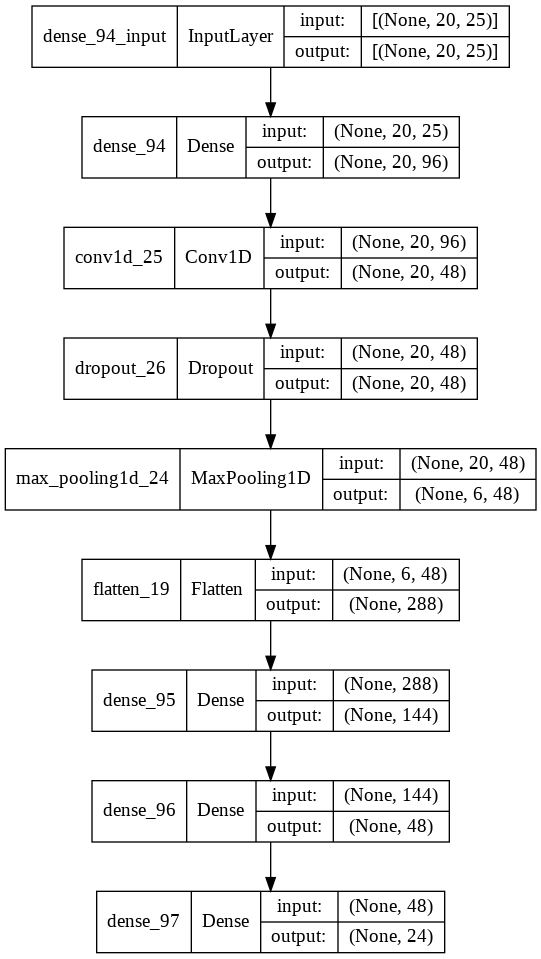

In [ ]:
plot_model(cnn_model, to_file='cnn_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from numpy import array
nb_e = 80
b_s = 20
history = cnn_model.fit(X_train,y_train, batch_size= b_s, validation_split=0.25, verbose=1, epochs= nb_e)
loss, acc = cnn_model.evaluate(X_test, y_test)

Epoch 1/80
1326/1326 [==============================] - 6s 5ms/step - loss: 0.4776 - accuracy: 0.8532 - val_loss: 0.4254 - val_accuracy: 0.8967
Epoch 2/80
1326/1326 [==============================] - 7s 5ms/step - loss: 0.4769 - accuracy: 0.8563 - val_loss: 0.4279 - val_accuracy: 0.8958
Epoch 3/80
1326/1326 [==============================] - 7s 5ms/step - loss: 0.4721 - accuracy: 0.8544 - val_loss: 0.4199 - val_accuracy: 0.8964
Epoch 4/80
1326/1326 [==============================] - 7s 5ms/step - loss: 0.4784 - accuracy: 0.8547 - val_loss: 0.4218 - val_accuracy: 0.8979
Epoch 5/80
1326/1326 [==============================] - 7s 5ms/step - loss: 0.4731 - accuracy: 0.8560 - val_loss: 0.4173 - val_accuracy: 0.8963
Epoch 6/80
1326/1326 [==============================] - 7s 5ms/step - loss: 0.4742 - accuracy: 0.8561 - val_loss: 0.4187 - val_accuracy: 0.8976
Epoch 7/80
1326/1326 [==============================] - 8s 6ms/step - loss: 0.4690 - accuracy: 0.8556 - val_loss: 0.4164 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


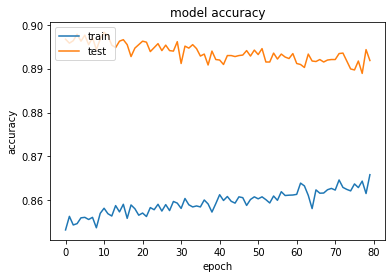

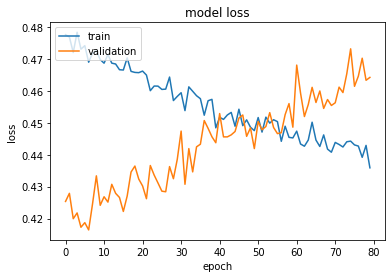

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Other Varients of CNN


In [50]:
nb_e = 15
b_s = 20
history = cnn_model.fit(X_train,y_train, batch_size= b_s, validation_split=0.25, verbose=1, epochs= nb_e)
loss, acc = cnn_model.evaluate(X_test, y_test)

Epoch 1/15
1326/1326 [==============================] - 26s 20ms/step - loss: 0.2968 - accuracy: 0.9116 - val_loss: 0.5355 - val_accuracy: 0.8898
Epoch 2/15
1326/1326 [==============================] - 24s 18ms/step - loss: 0.2891 - accuracy: 0.9135 - val_loss: 0.5460 - val_accuracy: 0.8846
Epoch 3/15
1326/1326 [==============================] - 24s 18ms/step - loss: 0.2875 - accuracy: 0.9156 - val_loss: 0.5453 - val_accuracy: 0.8889
Epoch 4/15
1326/1326 [==============================] - 24s 18ms/step - loss: 0.2886 - accuracy: 0.9132 - val_loss: 0.5504 - val_accuracy: 0.8873
Epoch 5/15
1326/1326 [==============================] - 25s 19ms/step - loss: 0.2795 - accuracy: 0.9181 - val_loss: 0.5426 - val_accuracy: 0.8878
Epoch 6/15
1326/1326 [==============================] - 24s 18ms/step - loss: 0.2801 - accuracy: 0.9173 - val_loss: 0.5591 - val_accuracy: 0.8876
Epoch 7/15
1326/1326 [==============================] - 24s 18ms/step - loss: 0.2775 - accuracy: 0.9184 - val_loss: 0.5652 -

In [ ]:
optimizers = ["rmsprop", "adam"]

# define the optimizer function
def create_model(optimizer="rmsprop", kernel_initializer="glorot_uniform"):
  cnn_model = tf.keras.Sequential()
  cnn_model.add(Dense(100, activation='relu', input_shape=(20,25)))
  cnn_model.add(Conv1D(filters=20, kernel_size=2, padding='same', activation='relu' ))
  cnn_model.add(Dropout(0.2))
  cnn_model.add(MaxPooling1D(pool_size=2))
  cnn_model.add(Flatten())
  cnn_model.add(Dense(50, activation='sigmoid'))
  cnn_model.add(layers.Dense(24, activation='softmax'))
  cnn_model.compile(optimizer=optimizers, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
  cnn_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=["accuracy"])
  return cnn_model

cnn_model = KerasClassifier(build_fn=create_model)

kernel_initializer = ["glorot_uniform", "normal"]
epochs = [35, 60]
param_grid = dict(
    optimizer=optimizers,
    nb_epoch=epochs,
    kernel_initializer=kernel_initializer)
grid = TuneGridSearchCV(estimator=cnn_model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)
print(grid_result.best_params_)
print(grid_result.cv_results_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
/usr/local/lib/python3.7/dist-packages/ray/tune/tune.py:374: UserWarning: The `loggers` argument is deprecated. Please pass the respective `LoggerCallback` classes to the `callbacks` argument instead. See https://docs.ray.io/en/latest/tune/api_docs/logging.html
  "The `loggers` argument is deprecated. Please pass the respective "
(_Trainable pid=1428) 2022-01-26 22:09:07.244814: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_Trainable pid=1427) 2022-01-26 22:09:07.750022: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


220/884 [======>.......................] - ETA: 5s - loss: 1.9367 - accuracy: 0.4491
(_Trainable pid=1427) 
(_Trainable pid=1427) 227/884 [======>.......................] - ETA: 5s - loss: 1.9243 - accuracy: 0.4544
752/884 [========================>.....] - ETA: 1s - loss: 1.2733 - accuracy: 0.6671
(_Trainable pid=1428)  - ETA: 0s - loss: 0.8763 - accuracy: 0.7923
151/884 [====>.........................] - ETA: 6s - loss: 2.0731 - accuracy: 0.3694
(_Trainable pid=1427) 
272/884 [========>.....................] - ETA: 5s - loss: 1.8042 - accuracy: 0.4756
(_Trainable pid=1428)  - ETA: 2s - loss: 1.4066 - accuracy: 0.6054
711/884 [=======================>......] - ETA: 1s - loss: 1.3249 - accuracy: 0.6325
(_Trainable pid=1428) 717/884 [=====

### This Cell won't run now as the input size is different now 
##### (This is just for ref of diffferent batch sizes)
- epochs = 35
- bs = 60
- optimizer = adam

In [ ]:
from tensorflow.keras import layers
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, Flatten, Dropout

cnn_model = tf.keras.Sequential()
cnn_model.add(Dense(100, activation='relu', input_shape=(60,25)))

cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(64, activation='sigmoid'))
cnn_model.add(Flatten())
cnn_model.add(Dense(48, activation='sigmoid'))
cnn_model.add(layers.Dense(24, activation='softmax'))
cnn_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])


In [ ]:
from numpy import array
nb_e = 35
b_s = 60
history = cnn_model.fit(X_train,y_train, batch_size= b_s, validation_split=0.25, verbose=1, epochs= nb_e)
loss, acc = cnn_model.evaluate(X_test, y_test)

Epoch 1/35
442/442 [==============================] - 7s 12ms/step - loss: 1.9477 - accuracy: 0.4535 - val_loss: 0.7531 - val_accuracy: 0.8631
Epoch 2/35
442/442 [==============================] - 5s 11ms/step - loss: 0.9241 - accuracy: 0.7834 - val_loss: 0.5262 - val_accuracy: 0.8805
Epoch 3/35
442/442 [==============================] - 5s 11ms/step - loss: 0.7728 - accuracy: 0.8070 - val_loss: 0.4805 - val_accuracy: 0.8887
Epoch 4/35
442/442 [==============================] - 5s 11ms/step - loss: 0.7142 - accuracy: 0.8179 - val_loss: 0.4528 - val_accuracy: 0.8942
Epoch 5/35
442/442 [==============================] - 5s 11ms/step - loss: 0.6743 - accuracy: 0.8256 - val_loss: 0.4330 - val_accuracy: 0.8969
Epoch 6/35
442/442 [==============================] - 5s 10ms/step - loss: 0.6476 - accuracy: 0.8297 - val_loss: 0.4198 - val_accuracy: 0.8986
Epoch 7/35
442/442 [==============================] - 4s 10ms/step - loss: 0.6257 - accuracy: 0.8331 - val_loss: 0.4196 - val_accuracy: 0.8974

# ARAS DataSet


In [ ]:
df_a = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/processed_data/Aras_HouseA.csv")
df_a

,Unnamed: 0,sensor_id,value,time,old_sen
0,0,5889,1,49,3
1,1,5889,0,252,3
2,2,5889,1,301,3
3,3,5889,0,504,3
4,4,5889,1,505,3
...,...,...,...,...,...
53873,53873,7125,0,85987,17
53874,53874,5888,0,85992,11
53875,53875,5893,1,86001,15
53876,53876,5893,0,86004,15


In [ ]:
def create_on_off_Multi_int():
    '''
    dictionary 
    :return: Dictionary of int encoding
    '''
    dic_on_off = {}
    dic_on_off[5895] = [0,1]
    dic_on_off[7125] = [2, 3]
    dic_on_off[5896] = [4,5]
    dic_on_off[6253] = [6, 7]
    dic_on_off[6632] = [8, 9]
    dic_on_off[6633] = [10, 11]
    dic_on_off[6635] = [12, 13]
    dic_on_off[6896] = [14, 15]
    dic_on_off[5887] = [16, 17]
    dic_on_off[5888] = [18, 19]
    dic_on_off[5889] = [20, 21]
    dic_on_off[5893] = [22, 23]
    return dic_on_off

def add_event_col(df, dic):
    
    '''
    adds a column to the data set which combines value and event col
    :param df: 
    :param dic: int or char representation
    :return: 
    '''

    add = []

    for index, row in df.iterrows():

        sensor = row["sensor_id"]
        value = int(row["value"])

        add.append(dic[sensor][value])

    df["event"] = np.array(add)
    return df
  
dic_on_off_int = create_on_off_Multi_int()
df_a = add_event_col(df_a, dic_on_off_int)

df_a['time_scal'] = df_a['time']/86400
df_a = df_a[["event", "time_scal"]]

df = data.reset_index(drop = True)
## initialize 24 * n_datapoints array
len = df.shape[0]
n_event = 24
enc = [[0 for i in range(len)] for j in range(n_event)]
enc = np.array(enc)

## fill array
for i in range(0, df.shape[0]):

    sen = df.loc[i, "event"]
    enc[sen, i] = 1

dt = {"time_scal" :df["time_scal"],'0' : enc[0], '1': enc[1], '2' : enc[2], '3': enc[3], '4': enc[4], '5': enc[5],
      '6' : enc[6], '7': enc[7], '8' : enc[8], '9': enc[9], '10': enc[10], '11': enc[11],
      '12' : enc[12], '13': enc[13], '14' : enc[14], '15': enc[15], '16': enc[16], '17': enc[17],
      '18' : enc[18], '19': enc[19], '20' : enc[20], '21': enc[21], '22': enc[22], '23': enc[23]
      }
df3 = pd.DataFrame(data = dt)

X_test_a =[]
y_test_a =[]
test_data_a = df3.values
for i in range(20,len(test_data_a)):
    X_test_a.append(test_data_a[i-20:i, :])
    y_test_a.append(test_data_a[i, 1:])

X_test_a, y_test_a = np.array(X_test_a), np.array(y_test_a)

In [ ]:
print(len(X_test_a))
print(len(y_test_a))
print(X_test_a.shape)
print(y_test_a.shape)

53858
53858
(53858, 20, 25)
(53858, 24)


In [ ]:
# CNN Model
aras_cnn = cnn_model.predict(X_test_a)
y_pred_a= []
for i in range(0,len(aras_cnn)): 
  y_pred_a.append(np.argmax(aras_cnn[i]))

y_test_a_fy= []
for i in range(0,len(y_test_a)): 
  y_test_a_fy.append(np.argmax(y_test_a[i]))

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_a_fy, y_pred_a)
print(classification_report(y_test_a_fy, y_pred_a))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     13469
           1       0.94      0.98      0.96      3813
           2       0.45      0.11      0.18       374
           3       0.75      0.68      0.72       374
           4       0.94      0.92      0.93      1751
           5       0.76      0.80      0.78      1751
           6       0.93      0.94      0.93      1051
           7       0.59      0.43      0.50      1051
           8       0.91      0.96      0.93      1344
           9       0.77      0.84      0.80      1343
          10       0.70      0.53      0.61       111
          11       0.51      0.18      0.27       110
          12       0.71      0.45      0.56        11
          13       0.00      0.00      0.00        10
          14       0.67      0.42      0.52        38
          15       0.60      0.08      0.14        37
          16       0.95      0.93      0.94      3575
          17       0.91    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# LSTM Model
aras_lstm = sl_model.predict(X_test_a)
y_pred_a_sl= []
for i in range(0,len(aras_lstm)): 
  y_pred_a_sl.append(np.argmax(aras_lstm[i]))

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_a_fy, y_pred_a_sl)
print(classification_report(y_test_a_fy, y_pred_a_sl))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     13469
           1       0.94      0.95      0.94      3813
           2       0.42      0.02      0.04       374
           3       0.74      0.73      0.74       374
           4       0.92      0.90      0.91      1751
           5       0.73      0.80      0.76      1751
           6       0.95      0.86      0.90      1051
           7       0.44      0.46      0.45      1051
           8       0.87      0.99      0.92      1344
           9       0.73      0.84      0.78      1343
          10       0.60      0.52      0.56       111
          11       0.00      0.00      0.00       110
          12       0.50      0.09      0.15        11
          13       0.00      0.00      0.00        10
          14       0.47      0.42      0.44        38
          15       0.00      0.00      0.00        37
          16       0.94      0.91      0.93      3575
          17       0.91    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
